# Evaluate Synthesis PLM-ICD on rare codes

Notebook này thực hiện nhiệm vụ:
- Đánh giá hiệu quả gán nhãn của mô hình PLM-ICD sau khi được fine-tuned trên dữ liệu tổng hợp
- So sánh hiệu quả của mô hình sau khi train với các mô hình trước khi train, đặc biệt trên các loại mã hiếm
- Nếu sử dụng Colab hoặc Kaggle, vui lòng restart kernel notebook sau khi reinstall các package ở cell đầu tiên

In [ ]:
!git clone https://github.com/chancholat/explain-icd.git
!pip install -q datasets==3.4.1

Cloning into 'explain-icd'...
remote: Enumerating objects: 1392, done.
remote: Counting objects: 100% (1392/1392), done.
remote: Compressing objects: 100% (677/677), done.
remote: Total 1392 (delta 743), reused 1349 (delta 700), pack-reused 0 (from 0)
Receiving objects: 100% (1392/1392), 4.37 MiB | 8.10 MiB/s, done.
Resolving deltas: 100% (743/743), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires n

In [ ]:
import kagglehub

# download dataset from kaggle
kagglehub.dataset_download('chanhainguyen/thesis-data-process')

'/kaggle/input/thesis-data-process'

In [ ]:
# !mv /root/.cache/kagglehub/datasets/chanhainguyen/thesis-data-process/versions/1/processed /content/explain-icd/data
!mv /kaggle/input/thesis-data-process/processed /content/explain-icd/data

mv: cannot remove '/kaggle/input/thesis-data-process/processed/mdace_icd9_inpatient_code/train.parquet': Read-only file system
mv: cannot remove '/kaggle/input/thesis-data-process/processed/mdace_icd9_inpatient_code/test.parquet': Read-only file system
mv: cannot remove '/kaggle/input/thesis-data-process/processed/mdace_icd9_inpatient_code/val.parquet': Read-only file system
mv: cannot remove '/kaggle/input/thesis-data-process/processed/mimiciv_icd9/train.parquet': Read-only file system
mv: cannot remove '/kaggle/input/thesis-data-process/processed/mimiciv_icd9/test.parquet': Read-only file system
mv: cannot remove '/kaggle/input/thesis-data-process/processed/mimiciv_icd9/val.parquet': Read-only file system
mv: cannot remove '/kaggle/input/thesis-data-process/processed/mdace_notes.parquet': Read-only file system
mv: cannot remove '/kaggle/input/thesis-data-process/processed/mimiciii_50/train.parquet': Read-only file system
mv: cannot remove '/kaggle/input/thesis-data-process/processed/

## Evaluation

### Evaluate with trainer

In [ ]:
!pip install -q python-dotenv==1.0.0
!pip install -q omegaconf==2.3.0
!pip install -q captum==0.7.0
!pip install -q hydra-core
!pip install -q --force-reinstall transformers==4.38.1
!pip install -q --force-reinstall scikit-learn==1.3.0
!pip install -q --force-reinstall numpy==1.26.2

!mkdir /content/src
!gdown --folder https://drive.google.com/drive/folders/1b3tBwPYlPx0j-3pdJy4Na6wQBZUTJezv -O /content/src

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
import os

# Change to a specific directory
os.chdir("/content/explain-icd")

In [ ]:
!mkdir /content/explain-icd/models
from huggingface_hub import snapshot_download

# Tải toàn bộ repository về thư mục local
snapshot_download(repo_id="ChanBeDu/PLM-ICD-seed10", repo_type="model", local_dir="/content/explain-icd/models")

In [ ]:
from hydra import initialize_config_dir, compose
import os

# Get the absolute path of the configuration directory
config_dir = os.path.abspath("explainable_medical_coding/config")

# with initialize_config_dir(config_dir=config_dir, job_name="test_app"):
#     cfg = compose(config_name="config", overrides=[
#         "experiment=mimic_iii_clean/plm_icd_supervised"
#     ])


# with initialize_config_dir(config_dir=config_dir, job_name="test_app"):
#     cfg = compose(config_name="config", overrides=[
#         "experiment=mdace_icd9_code/plm_icd_supervised"
#     ])

with initialize_config_dir(config_dir=config_dir, job_name="test_app"):
    cfg = compose(config_name="config", overrides=[
        "experiment=mdace_icd9_code/plm_icd"
    ])

# with initialize_config_dir(config_dir=config_dir, job_name="test_app"):
#     cfg = compose(config_name="config", overrides=[
#         "experiment=mdace_icd9_rare/plm_icd_supervised"
#     ])

/tmp/ipython-input-3-3011230569.py:18: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize_config_dir(config_dir=config_dir, job_name="test_app"):


In [ ]:
import torch
import os
import sys
from pathlib import Path
sys.path.append('/content/explain-icd')

from datasets import load_dataset
from omegaconf import OmegaConf
from transformers import AutoTokenizer

import explainable_medical_coding.config.factories as factories
from explainable_medical_coding.utils.loaders import (
    load_trained_model,
)
from explainable_medical_coding.utils.tokenizer import TargetTokenizer
from explainable_medical_coding.utils.analysis import predict
from explainable_medical_coding.utils.data_helper_functions import (
    create_targets_column,
    filter_unknown_targets,
    format_evidence_spans,
    get_unique_targets,
)

/content/explain-icd/explainable_medical_coding/utils/loss_functions.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  diet_gradient_scaler = torch.cuda.amp.GradScaler()
/content/explain-icd/explainable_medical_coding/utils/loss_functions.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  advesarial_noise_gradient_scaler = torch.cuda.amp.GradScaler()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if "CUDA_VISIBLE_DEVICES" not in os.environ:
  print("CUDA_VISIBLE_DEVICES not set")
  os.environ["CUDA_VISIBLE_DEVICES"] = "0"

CUDA_VISIBLE_DEVICES not set


In [ ]:
target_columns = list(cfg.data.target_columns)
dataset_path = Path(cfg.data.dataset_path)
# model_path = Path(cfg.load_model) if cfg.load_model is not None else None
dataset = load_dataset(str(dataset_path))

In [ ]:
from explainable_medical_coding.utils.settings import TARGET_COLUMN, TEXT_COLUMN

text_tokenizer = AutoTokenizer.from_pretrained(cfg.model.configs.model_path,)
max_input_length = int(cfg.data.max_length)
# tokenize text
dataset = dataset.map(
    lambda x: text_tokenizer(
        x[TEXT_COLUMN],
        return_length=True,
        truncation=True,
        max_length=max_input_length,
    ),
    batched=True,
    # num_proc=8,
    num_proc=4,
    batch_size=1_000,
    desc="Tokenizing text",
)

In [ ]:
import logging
LOGGER = logging.getLogger(name="test evaluate")
LOGGER.setLevel(logging.INFO)

model_folder_path = Path('models')
# run_id = 'supervised/ym0o7co8'
run_id = 'unsupervised/vxrn54op'
model_path = model_folder_path / run_id

In [ ]:
dataset = dataset.map(
    lambda x: create_targets_column(x, target_columns),
    desc="Creating targets column",
)
known_targets = set(get_unique_targets(dataset))
dataset = dataset.map(
    lambda x: filter_unknown_targets(x, known_targets=known_targets),
    desc="Filter unknown targets",
)
dataset = dataset.filter(
    lambda x: len(x[TARGET_COLUMN]) > 0, desc="Filtering empty targets"
)
dataset = dataset.map(lambda x: format_evidence_spans(x, text_tokenizer))

autoregressive = bool(cfg.model.autoregressive)
target_tokenizer = TargetTokenizer(autoregressive=autoregressive)
if model_path is None:
    unique_targets = get_unique_targets(dataset)
    target_tokenizer.fit(unique_targets)
else:
    LOGGER.info("Loading Tokenizer from model_path")
    target_tokenizer.load(model_path / "target_tokenizer.json")

# convert targets to target ids
dataset = dataset.map(
    lambda x: {"target_ids": target_tokenizer(x[TARGET_COLUMN])},
    desc="Converting targets to target ids",
)
dataset.set_format(
    type="torch", columns=["input_ids", "length", "attention_mask", "target_ids"]
)

INFO:test evaluate:Loading Tokenizer from model_path


Converting targets to target ids:   0%|          | 0/48074 [00:00<?, ? examples/s]

Converting targets to target ids:   0%|          | 0/1753 [00:00<?, ? examples/s]

Converting targets to target ids:   0%|          | 0/3197 [00:00<?, ? examples/s]

In [ ]:
lookups = factories.get_lookups(
      dataset=dataset,
      text_tokenizer=text_tokenizer,
      target_tokenizer=target_tokenizer,
  )
LOGGER.info(lookups.data_info)

/content/explain-icd/explainable_medical_coding/utils/lookups.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  split2code_indices[split_name] = torch.tensor(target_ids)
INFO:test evaluate:{'num_examples': 53024, 'num_train_examples': 48074, 'num_val_examples': 1753, 'num_test_examples': 3197, 'average_words_per_example': 3599.9838426744996, 'average_targets_per_example': 16.58517683512171, 'num_classes': 8943, 'num_train_classes': 8712, 'num_val_classes': 3044, 'num_test_classes': 3980, 'vocab_size': 50001, 'pad_token_id': 1, 'pad_target_id': -1, 'sos_target_id': None, 'eos_target_id': None}


In [ ]:
if model_path is None:
    model = factories.get_model(config=cfg.model, data_info=lookups.data_info)
else:
    LOGGER.info("Loading Model from model_path")
    saved_config = OmegaConf.load(model_path / "config.yaml")
    model, decision_boundary = load_trained_model(
        model_path,
        saved_config,
        pad_token_id=text_tokenizer.pad_token_id,
        device=device,
    )

model.to(device)

INFO:test evaluate:Loading Model from model_path


{'name': 'PLMICD', 'autoregressive': False, 'configs': {'model_path': 'models/roberta-base-pm-m3-voc-hf', 'chunk_size': 128, 'cross_attention': True, 'loss': 'binary_cross_entropy', 'lambda_1': 0.0, 'scale': 1, 'mask_input': False}}


PLMICD(
  (roberta_encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50008, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Laye

In [ ]:
import math

loss_function = factories.get_loss_function(config=cfg.loss)

dataloaders = factories.get_dataloaders(
    config=cfg.dataloader,
    dataset=dataset,
    target_tokenizer=lookups.target_tokenizer,
    pad_token_id=lookups.data_info["pad_token_id"],
)

metric_collections = factories.get_metric_collections(
    config=cfg.metrics,
    number_of_classes=lookups.data_info["num_classes"],
    split2code_indices=lookups.split2code_indices,
    autoregressive=cfg.model.autoregressive,
)

optimizer = factories.get_optimizer(config=cfg.optimizer, model=model)
accumulate_grad_batches = int(
    max(cfg.dataloader.batch_size / cfg.dataloader.max_batch_size, 1)
)
num_training_steps = (
    math.ceil(len(dataloaders["train"]) / accumulate_grad_batches)
    * cfg.trainer.epochs
)
lr_scheduler = factories.get_lr_scheduler(
    config=cfg.lr_scheduler,
    optimizer=optimizer,
    num_training_steps=num_training_steps,
)
callbacks = factories.get_callbacks(config=cfg.callbacks)
trainer_class = factories.get_trainer(name=cfg.trainer.name)
trainer = trainer_class(
    config=cfg,
    model=model,
    loss_function=loss_function,
    optimizer=optimizer,
    dataloaders=dataloaders,
    metric_collections=metric_collections,
    callbacks=callbacks,
    lr_scheduler=lr_scheduler,
    lookups=lookups,
    accumulate_grad_batches=accumulate_grad_batches,
).to(device)

'Train batch size: 16'

'Accumulating gradients over 1 batch(es).'

/content/explain-icd/explainable_medical_coding/trainer/trainer.py:55: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.gradient_scaler = torch.cuda.amp.GradScaler(enabled=self.use_amp)
wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.
wandb: Currently logged in as: chanhainguyen97 (chanhainguyen97-University of Science) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# evaluate on validation set
trainer.val(trainer.epoch, "validation", evaluating_best_model=True)

Output()

Best F1: 0.5963945388793945 at DB: 0.4040403962135315


'Best threshold: 0.4040403962135315'

'Best result: 0.5963945388793945'

In [ ]:
from google.colab import files

def download_result(file_path):
  # Download the file
  files.download(file_path)

# download_result("/content/explain-icd/models/tu85h4h1/predictions_validation.feather")
# download_result("/content/explain-icd/models/c5z74wyl/predictions_validation.feather")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Get prediction from hub

In [ ]:
!mkdir /content/explain-icd/models
!mkdir /content/explain-icd/models-synthesis

In [ ]:
from huggingface_hub import snapshot_download

# Tải toàn bộ repository về thư mục local
snapshot_download(repo_id="ChanBeDu/Synthesis-PLM-ICD", repo_type="model", local_dir="/content/explain-icd/models-synthesis")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

best_model.pt:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

best_model.pt:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

predictions_test.feather:   0%|          | 0.00/118M [00:00<?, ?B/s]

predictions_validation.feather:   0%|          | 0.00/66.5M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

target_tokenizer.json: 0.00B [00:00, ?B/s]

config.yaml: 0.00B [00:00, ?B/s]

predictions_test.feather:   0%|          | 0.00/118M [00:00<?, ?B/s]

predictions_validation.feather:   0%|          | 0.00/66.5M [00:00<?, ?B/s]

target_tokenizer.json: 0.00B [00:00, ?B/s]

config.yaml: 0.00B [00:00, ?B/s]

best_model.pt:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

config.yaml: 0.00B [00:00, ?B/s]

predictions_test.feather:   0%|          | 0.00/118M [00:00<?, ?B/s]

predictions_validation.feather:   0%|          | 0.00/66.5M [00:00<?, ?B/s]

target_tokenizer.json: 0.00B [00:00, ?B/s]

best_model.pt:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

predictions_test.feather:   0%|          | 0.00/118M [00:00<?, ?B/s]

config.yaml: 0.00B [00:00, ?B/s]

predictions_validation.feather:   0%|          | 0.00/66.5M [00:00<?, ?B/s]

target_tokenizer.json: 0.00B [00:00, ?B/s]

'/content/explain-icd/models'

### Analyse prediction result

In [ ]:
import os

# Change to a specific directory
os.chdir("/content/explain-icd")

In [ ]:
import torch
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from explainable_medical_coding.utils.decision_boundary import f1_score_db_tuning

# def filter_tensor(
#     self, tensor: torch.Tensor, code_indices: Optional[torch.Tensor]
# ) -> torch.Tensor:
#     if code_indices is None:
#         return tensor
#     return torch.index_select(tensor, -1, code_indices)

def tunning_f1(prediction_path, average='micro', rare_sets = [], is_on_rare = False):
  df = pd.read_feather(prediction_path)
  # 1. Extract logits
  # Exclude 'target' and '_id' columns to get the probability columns

  logit_columns = [col for col in df.columns if col not in ['target', '_id']]
  print(len(logit_columns))
  print(type(logit_columns))
  if is_on_rare:
    logit_columns = [col for col in logit_columns if col in rare_sets]
    print(len(logit_columns))
  logits_df = df[logit_columns]

  # Convert logits DataFrame to a PyTorch tensor
  # You might need to adjust the dtype based on your data
  logits = torch.tensor(logits_df.values, dtype=torch.float32)

  # 2. Convert target codes to one-hot encoded format
  # Get all unique codes from the logit columns to define the classes for one-hot encoding
  all_codes = logit_columns

  # Use MultiLabelBinarizer to create the one-hot encoded target matrix
  mlb = MultiLabelBinarizer(classes=all_codes)
  # The target column contains lists of codes, which is the expected input for fit_transform
  targets_one_hot = mlb.fit_transform(df['target'])

  # Convert the one-hot encoded targets to a PyTorch tensor
  targets = torch.tensor(targets_one_hot, dtype=torch.long)

  # Move tensors to the same device if you are using CUDA
  if torch.cuda.is_available():
      device = torch.device("cuda")
      logits = logits.to(device)
      targets = targets.to(device)
  else:
      device = torch.device("cpu")


  # Now you can use the f1_score_db_tuning function
  # Assuming the f1_score_db_tuning function is defined in your notebook
  best_f1, best_db = f1_score_db_tuning(logits, targets, average=average)

  print(f"\nUsing f1_score_db_tuning:")
  print(f"Best {average} F1 Score: {best_f1}")
  print(f"Best Decision Boundary: {best_db}")
  return best_f1, best_db

In [ ]:
file_path = "/content/predictions_validation_sa_seed9.feather"
best_f1, best_db = tunning_f1(file_path, average='macro')

8943
<class 'list'>
Best F1: 0.10973076522350311 at DB: 0.1515151560306549

Using f1_score_db_tuning:
Best macro F1 Score: 0.10973076522350311
Best Decision Boundary: 0.1515151560306549


In [ ]:
file_path = "/content/predictions_validation_sa_seed9.feather"
best_f1_mi, best_db_mi = tunning_f1(file_path, average='micro')

8943
<class 'list'>
Best F1: 0.5962522029876709 at DB: 0.3737373650074005

Using f1_score_db_tuning:
Best micro F1 Score: 0.5962522029876709
Best Decision Boundary: 0.3737373650074005


In [ ]:
file_path = "/content/predictions_validation_sa_seed9.feather"
best_f1, best_db = tunning_f1(file_path, average='macro')

In [ ]:
# file_path = "/content/mimiciii_clean_predictions_validation.feather"
# file_path = "/content/mdace_icd9_code_predictions_validation.feather"
file_path = "/content/explain-icd/models/c5z74wyl/predictions_validation.feather"
best_f1, best_db = tunning_f1(file_path, average='macro')

Best F1: 0.10543432831764221 at DB: 0.16161616146564484

Using f1_score_db_tuning:
Best Micro F1 Score: 0.10543432831764221
Best Decision Boundary: 0.16161616146564484


In [ ]:
file_path = "/content/explain-icd/models-synthesis/supervised-seed10-filter-notes-lr1e5/predictions_validation.feather"
best_f1, best_db = tunning_f1(file_path, average='macro')

Best F1: 0.053680598735809326 at DB: 0.04040404036641121

Using f1_score_db_tuning:
Best Micro F1 Score: 0.053680598735809326
Best Decision Boundary: 0.04040404036641121


In [ ]:
file_path = "/content/explain-icd/models-synthesis/supervised-seed10-filter-notes/predictions_validation.feather"
best_f1, best_db = tunning_f1(file_path, average='macro')

Best F1: 0.053680598735809326 at DB: 0.04040404036641121

Using f1_score_db_tuning:
Best Micro F1 Score: 0.053680598735809326
Best Decision Boundary: 0.04040404036641121


In [ ]:
import pandas as pd

augmented_rare_code_df = pd.read_csv("/content/code_freq_compare.csv")

# Calculate increase
augmented_rare_code_df['increase'] = augmented_rare_code_df['augmented_count'] - augmented_rare_code_df['original_count']

# Get top 10 codes with largest increase
top_10_codes = augmented_rare_code_df.sort_values(by='increase', ascending=False).head(1)['code'].tolist()
rare_sets = augmented_rare_code_df['code'].tolist()

In [ ]:
# file_path = "/content/explain-icd/models-synthesis/supervised-seed10-filter-notes/predictions_validation.feather"
file_path = "/content/explain-icd/models-synthesis/supervised-seed10/predictions_validation.feather"
best_f1, best_db = tunning_f1(file_path, average='macro', rare_sets=rare_sets, is_on_rare=True)
# best_f1, best_db = tunning_f1(file_path, average='macro', rare_sets=top_10_codes, is_on_rare=True)

8943
<class 'list'>
123
Best F1: 0.16345351934432983 at DB: 0.3636363744735718

Using f1_score_db_tuning:
Best Micro F1 Score: 0.16345351934432983
Best Decision Boundary: 0.3636363744735718


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['00.14', '00.15', '00.17', '00.18', '00.24', '00.34', '00.40', '00.41', '00.42', '00.43', '00.44', '00.45', '00.46', '00.47', '00.48', '00.51', '00.59', '00.61', '00.62', '00.63', '00.66', '00.71', '00.72', '00.80', '00.84', '00.91', '00.93', '003.8', '004.1', '008.41', '008.45', '008.69', '008.8', '009.0', '009.1', '01.09', '01.10', '01.13', '01.14', '01.23', '01.24', '01.25', '01.26', '01.27', '01.28', '01.31', '01.39', '01.51', '01.53', '01.59', '011.86', '011.90', '02.02', '02.04', '02.05', '02.06', '02.12', '02.2', '02.21', '02.33', '02.34', '02.39', '02.42', '02.43', '02.94', '027.0', '03.09', '03.31', '03.4', '03.53', '03.90', '03.92', '031.0', '031.9', '038.0', '038.10', '038.11', '038.19', '038.2', '038.3', '038.40', '038.42', '038.43', '038.44', '038.49', '038.8', '038.9', '04.3', '04.43', '04.81', '040.0', '040.82', '041.02', '041.04', '041.09', '041.10', '041.11', '0

In [ ]:
# file_path = "/content/explain-icd/models/c5z74wyl/predictions_validation.feather"
file_path = "/content/explain-icd/models/tu85h4h1/predictions_validation.feather"
best_f1, best_db = tunning_f1(file_path, average='macro', rare_sets=rare_sets, is_on_rare=True)
# best_f1, best_db = tunning_f1(file_path, average='macro', rare_sets=top_10_codes, is_on_rare=True)

8943
<class 'list'>
123
Best F1: 0.38973119854927063 at DB: 0.13131313025951385

Using f1_score_db_tuning:
Best Micro F1 Score: 0.38973119854927063
Best Decision Boundary: 0.13131313025951385


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['00.14', '00.15', '00.17', '00.18', '00.24', '00.34', '00.40', '00.41', '00.42', '00.43', '00.44', '00.45', '00.46', '00.47', '00.48', '00.51', '00.59', '00.61', '00.62', '00.63', '00.66', '00.71', '00.72', '00.80', '00.84', '00.91', '00.93', '003.8', '004.1', '008.41', '008.45', '008.69', '008.8', '009.0', '009.1', '01.09', '01.10', '01.13', '01.14', '01.23', '01.24', '01.25', '01.26', '01.27', '01.28', '01.31', '01.39', '01.51', '01.53', '01.59', '011.86', '011.90', '02.02', '02.04', '02.05', '02.06', '02.12', '02.2', '02.21', '02.33', '02.34', '02.39', '02.42', '02.43', '02.94', '027.0', '03.09', '03.31', '03.4', '03.53', '03.90', '03.92', '031.0', '031.9', '038.0', '038.10', '038.11', '038.19', '038.2', '038.3', '038.40', '038.42', '038.43', '038.44', '038.49', '038.8', '038.9', '04.3', '04.43', '04.81', '040.0', '040.82', '041.02', '041.04', '041.09', '041.10', '041.11', '0

### F1 - Frequency Analysing

In [ ]:
# prompt: kiểm tra trong file /content/explain-icd/models/kn4v14m6/predictions_validation.feather có chứa gì

import os
import pandas as pd

run_id = "uqpenr0i"
# file_path = f"/content/explain-icd/models/{run_id}/predictions_validation.feather"
# file_path = "/content/mdace_icd9_code_predictions_validation.feather"
# file_path = "/content/mimiciii_clean_predictions_validation.feather"
file_path = "/content/predictions_validation_sa_seed9.feather"


if os.path.exists(file_path):
    print(f"File '{file_path}' tồn tại.")
    try:
        # Thử đọc file như định dạng Feather (hoặc Parquet)
        df = pd.read_feather(file_path)
        print("Nội dung của file:")
        print(df.head()) # In ra vài dòng đầu tiên
        print("\nThông tin về DataFrame:")
        df.info()
    except Exception as e:
        print(f"Không thể đọc file. Lỗi: {e}")
else:
    print(f"File '{file_path}' không tồn tại.")


File '/content/predictions_validation_sa_seed9.feather' tồn tại.
Nội dung của file:
         532.11         698.8        813.07         354.0         049.8  \
0  5.430719e-08  6.320904e-08  7.428820e-08  4.017995e-08  7.705311e-08   
1  2.055821e-07  2.781051e-07  3.795146e-07  1.701560e-07  2.740202e-07   
2  1.533738e-07  3.895207e-08  1.350568e-07  3.413659e-08  8.953503e-08   
3  2.986160e-07  1.039776e-06  6.890134e-07  2.769982e-07  4.744199e-07   
4  1.279280e-06  5.870956e-05  1.106926e-06  3.498984e-05  7.084127e-07   

          344.1         53.49        E958.3     041.4         88.55  ...  \
0  3.465916e-07  7.055917e-08  8.525001e-08  0.000293  1.583194e-07  ...   
1  1.393822e-07  1.907894e-07  4.062738e-07  0.000011  9.999277e-08  ...   
2  5.099834e-06  3.591055e-07  1.120834e-07  0.000008  5.872198e-06  ...   
3  1.259406e-07  3.778484e-07  8.147017e-07  0.000007  2.968284e-07  ...   
4  8.247587e-06  2.800438e-04  5.467657e-07  0.003295  6.029020e-04  ...   

        

In [ ]:
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

icd_codes = [col for col in df.columns if col not in ["target", "_id"]]

f1_scores = {}

for code in tqdm(icd_codes):
    y_true = df["target"].apply(lambda codes: code in codes).astype(int)
    # Ép kiểu db từ tensor về numpy
    # db = trainer.best_db.cpu().numpy()
    # db = best_db.cpu().numpy()
    db = best_db_mi.cpu().numpy()
    y_pred = (df[code] >= db).astype(int)

    if y_true.sum() == 0:
        continue  # bỏ qua nếu không có ground truth nào cho mã này

    f1_scores[code] = f1_score(y_true, y_pred)

100%|██████████| 8943/8943 [02:31<00:00, 58.98it/s]


In [ ]:
def get_all_codes(df, column_name='diagnosis_codes'):
    all_codes = [
    code
    for sublist in df[column_name]
    if sublist is not None
    for code in sublist
    ]
    return all_codes

# Concatenate the lists in 'procedure_codes' and 'diagnosis_codes' for each row
def getAllCodeInTrainDf(df):
    all_diagnosis_codes = get_all_codes(df, column_name='diagnosis_codes')
    all_procedure_codes = get_all_codes(df, column_name='procedure_codes')
    all_codes_in_train = all_diagnosis_codes + all_procedure_codes
    print(len(all_codes_in_train))
    return all_codes_in_train

def getCodeFrequency(df):
    all_codes_in_train = getAllCodeInTrainDf(df)
    frequency = {}
    for code in tqdm(all_codes_in_train):
        if code in frequency:
            frequency[code] += 1
        else:
            frequency[code] = 1
    return frequency

In [ ]:
import pandas as pd
train_df = pd.read_parquet("/content/explain-icd/data/processed/mdace_icd9_inpatient/train.parquet")
full_train_df = pd.read_parquet("/content/explain-icd/data/processed/mimiciii_full/train.parquet")
clean_train_df = pd.read_parquet("/content/explain-icd/data/processed/mimiciii_clean/train.parquet")
train_code_df = pd.read_parquet("/content/explain-icd/data/processed/mdace_icd9_inpatient_code/train.parquet")
val_code_df = pd.read_parquet("/content/explain-icd/data/processed/mdace_icd9_inpatient_code/val.parquet")
# tính frequency of each code in 'diagnosis_codes' and 'procedure_codes' of clean_train_df
full_frequency = getCodeFrequency(full_train_df)
clean_frequency = getCodeFrequency(clean_train_df)
mdace_frequency = getCodeFrequency(train_df)
mdacer_code_frequency = getCodeFrequency(train_code_df)
mdace_code_val_freq = getCodeFrequency(val_code_df)

748306


100%|██████████| 748306/748306 [00:00<00:00, 1845987.04it/s]


598481


100%|██████████| 598481/598481 [00:00<00:00, 3568362.87it/s]


2160


100%|██████████| 2160/2160 [00:00<00:00, 1184738.67it/s]


750466


100%|██████████| 750466/750466 [00:00<00:00, 3299516.39it/s]


29085


100%|██████████| 29085/29085 [00:00<00:00, 2775179.30it/s]


In [ ]:
# load calculated f1 df from csv file
# result_df = pd.read_csv("/content/f1_mdace_icd9code_scores.csv")
# Lưu lại tất cả F1Score và frequency của các mã bệnh
result_df = pd.DataFrame(list(f1_scores.items()), columns=["Code", "F1 Score"])
result_df["Full Frequency"] = result_df["Code"].map(full_frequency)
result_df["Clean Frequency"] = result_df["Code"].map(clean_frequency)
result_df["Mdace Frequency"] = result_df["Code"].map(mdace_frequency)
result_df["Mdace Code Frequency"] = result_df["Code"].map(mdacer_code_frequency)
# result_df.to_csv("f1_micro_sa_s9_mdacecode.csv", index=False)

### Filter rare F1

In [ ]:
rare_result_df = result_df[result_df['Code'].isin(rare_codes)]
rare_result_df = result_df[result_df['Code'].isin(rare_codes)]
stats = rare_result_df.describe().loc[['mean', 'std', 'min', 'max']](stats)

In [ ]:

import matplotlib.pyplot as plt
# Plot line chart of 'value' and 'score' over 'day'
def plot_line_chart(df, colx, coly, xlabel=None, ylabel=None, figsize=(8,5), sortByY = True):

  plt.figure(figsize=figsize)
  if sortByY:
    df = df.sort_values(by=coly)

  plt.plot(df[colx], df[coly], label='Value', marker='o')

  plt.title('Line Chart of Value and Score')
  plt.xlabel(xlabel if xlabel else colx)
  plt.ylabel(ylabel if ylabel else coly)
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

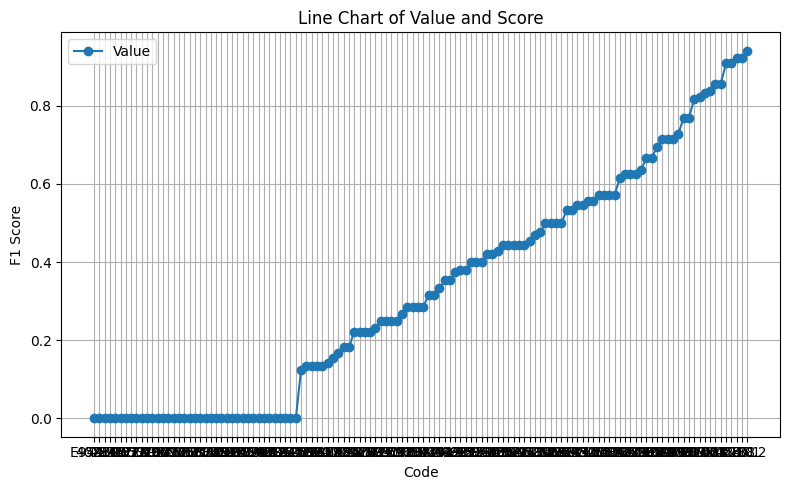

In [ ]:
plot_line_chart(rare_result_df, 'Code', 'F1 Score')

#### Select rare diagnosis codes

In [ ]:
from datasets import load_dataset
from pathlib import Path
# SIZE = 10
# mimic = load_dataset(str(dataset_path), split=f"train[:{SIZE}]", trust_remote_code=True)
dataset_path = Path("/content/explain-icd/data/processed/mdace_icd9_inpatient_code")
mimic = load_dataset(str(dataset_path), trust_remote_code=True)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
import pandas as pd
from collections import Counter

train_dx = mimic['train'].to_pandas()[['diagnosis_codes', 'note_id']]
train_proc = mimic['train'].to_pandas()[['procedure_codes', 'note_id']]

val_dx_codes = mimic['validation']['diagnosis_codes']
val_proc_codes = mimic['validation']['procedure_codes']

train_dx_code_count = Counter([code for sublist in train_dx['diagnosis_codes'] for code in sublist])
train_proc_code_count = Counter([code for sublist in train_proc['procedure_codes'] for code in sublist])

val_dx_code_count = Counter([code for sublist in val_dx_codes for code in sublist])
val_proc_code_count = Counter([code for sublist in val_proc_codes for code in sublist])

num_train_dx_code = len(train_dx_code_count)
num_train_proc_code = len(train_proc_code_count)
total_train_dx_code = sum(train_dx_code_count.values())
total_train_proc_code = sum(train_proc_code_count.values())

num_val_dx_code = len(val_dx_code_count)
num_val_proc_code = len(val_proc_code_count)
total_val_dx_code = sum(val_dx_code_count.values())
total_val_proc_code = sum(val_proc_code_count.values())

print(f"Number of train diagnosis codes: {num_train_dx_code}")
print(f"Number of train procedure codes: {num_train_proc_code}")
print(f"Total number of train diagnosis codes: {total_train_dx_code}")
print(f"Total number of train procedure codes: {total_train_proc_code}")
print()
print(f"Number of validation diagnosis codes: {num_val_dx_code}")
print(f"Number of validation procedure codes: {num_val_proc_code}")
print(f"Total number of validation diagnosis codes: {total_val_dx_code}")
print(f"Total number of validation procedure codes: {total_val_proc_code}")

Number of train diagnosis codes: 6741
Number of train procedure codes: 1971
Total number of train diagnosis codes: 549845
Total number of train procedure codes: 200621

Number of validation diagnosis codes: 2394
Number of validation procedure codes: 650
Total number of validation diagnosis codes: 23313
Total number of validation procedure codes: 5772


In [ ]:
import pandas as pd
from collections import Counter

# Flatten all codes
# It is important that we only synthesis the dianosis code,
# Because the procedure code is assigned based on how each specific desease is diagnosis

# Step 3: Assign to DataFrame
# train_df = pd.DataFrame()
# val_df = pd.DataFrame()
# train_df["train_dx_codes"] = [codes for codes in train_dx_codes if isinstance(codes, list) and len(codes) > 0]
# val_df["val_dx_codes"] = [codes for codes in val_dx_codes if isinstance(codes, list) and len(codes) > 0]
all_train_codes = [code for row in train_dx["diagnosis_codes"] for code in row]
all_val_codes = [code for row in val_dx_codes for code in row]
train_code_freq = Counter(all_train_codes)
val_code_freq = Counter(all_val_codes)

In [ ]:
import numpy as np


def get_percentiles(freq_values):
  # Compute quartiles
  q1 = np.percentile(freq_values, 25)   # First quartile (Q1)
  q2 = np.percentile(freq_values, 50)   # Second quartile (median, Q2)
  q3 = np.percentile(freq_values, 75)   # Third quartile (Q3)
  q87 = np.percentile(freq_values, 87.5)
  q90 = np.percentile(freq_values, 90)
  q93 = np.percentile(freq_values, 93)
  q96 = np.percentile(freq_values, 96)
  q99 = np.percentile(freq_values, 99)
  q4 = np.max(freq_values)              # Fourth quartile (max)

  print(f"Q1 (25th percentile): {q1}")
  print(f"Q2 (Median): {q2}")
  print(f"Q3 (75th percentile): {q3}")
  print(f"Q87.5 (87.5th percentile): {q87}")
  print(f"Q90 (90th percentile): {q90}")
  print(f"Q93 (93th percentile): {q93}")
  print(f"Q96 (96th percentile): {q96}")
  print(f"Q99 (99th percentile): {q99}")
  print(f"Q4 (Max): {q4}")
  print()
  return q87, q90, q93, q96, q99, q4, q3, q2, q1

q87, q90, q93, q96, q99, q4, q3, q2, q1 = get_percentiles(np.array(list(train_code_freq.values())))
_, val_q90, _, _, _, val_q4, val_q3, val_q2, val_q1 = get_percentiles(np.array(list(val_code_freq.values())))

Q1 (25th percentile): 2.0
Q2 (Median): 5.0
Q3 (75th percentile): 26.0
Q87.5 (87.5th percentile): 90.0
Q90 (90th percentile): 126.0
Q93 (93th percentile): 199.40000000000146
Q96 (96th percentile): 390.7999999999993
Q99 (99th percentile): 1290.6000000000022
Q4 (Max): 17963

Q1 (25th percentile): 1.0
Q2 (Median): 2.0
Q3 (75th percentile): 6.0
Q87.5 (87.5th percentile): 15.0
Q90 (90th percentile): 19.0
Q93 (93th percentile): 29.0
Q96 (96th percentile): 45.279999999999745
Q99 (99th percentile): 134.07000000000016
Q4 (Max): 735



In [ ]:
threshold = q90
val_threshold = val_q3
rare_codes = {code for code, freq in train_code_freq.items() if freq < threshold and val_code_freq[code] >= val_threshold}
frequent_codes = {code for code, freq in train_code_freq.items() if freq >= threshold}
anchor_sets = train_dx[train_dx["diagnosis_codes"].apply(lambda codes: any(code in frequent_codes for code in codes))]["diagnosis_codes"].tolist()
rare_code_sets = train_dx[train_dx["diagnosis_codes"].apply(lambda codes: any(code in rare_codes for code in codes))]["diagnosis_codes"].tolist()
mask = train_dx["diagnosis_codes"].apply(lambda codes: any(code in rare_codes for code in codes))
rare_df = train_dx.loc[mask]  # Keeps all columns
only_rare_code_sets = train_dx[train_dx["diagnosis_codes"].apply(lambda codes: all(code in rare_codes for code in codes))]["diagnosis_codes"].tolist()
rare_frequent_code_sets = train_dx[train_dx["diagnosis_codes"].apply(lambda codes: any(code in rare_codes for code in codes) and any(code in frequent_codes for code in codes))]["diagnosis_codes"].tolist()
print("frequent codes len: ", len(frequent_codes))
print("rare codes len: ", len(rare_codes))
print("frequent sets len: ", len(anchor_sets))
print("rare sets len: ", len(rare_code_sets))
print("only rare sets len: ", len(only_rare_code_sets))
print("rare frequent sets len: ", len(rare_frequent_code_sets))


frequent codes len:  676
rare codes len:  124
frequent sets len:  47804
rare sets len:  8825
only rare sets len:  24
rare frequent sets len:  8795


#### Filter rare code f1

### Thuy testing

In [ ]:
# # prompt: viết hàm nhận vào id trả về target và xác xuất của từng mã trong target đó

# def get_target_predictions(id):
#     """
#     Nhận vào id của bản ghi, trả về target và xác suất dự đoán cho từng mã trong target đó.

#     Args:
#         id (int): ID của bản ghi cần tra cứu.

#     Returns:
#         dict or None: Một từ điển chứa các target code và xác suất tương ứng
#                       cho bản ghi có ID đã cho, hoặc None nếu không tìm thấy ID.
#                       Ví dụ: {'code1': prob1, 'code2': prob2, ...}
#     """
#     # Kiểm tra xem DataFrame dự đoán có tồn tại không
#     if 'df' in locals() and not df.empty:
#         # Lọc DataFrame để tìm bản ghi với ID tương ứng
#         record = df[df['id'] == id]

#         if not record.empty:
#             # Lấy dòng đầu tiên (giả định ID là duy nhất)
#             record = record.iloc[0]

#             # Lấy danh sách target codes và xác suất từ cột 'predictions'
#             # Cột 'predictions' được giả định là một list các tuple (code, xác suất)
#             predictions_list = record.get('predictions')

#             if predictions_list and isinstance(predictions_list, list):
#                 # Tạo từ điển từ danh sách predictions
#                 target_probs = {code: prob for code, prob in predictions_list}
#                 return target_probs
#             else:
#                 print(f"Không tìm thấy dữ liệu dự đoán cho ID {id}.")
#                 return None
#         else:
#             print(f"Không tìm thấy bản ghi với ID {id} trong DataFrame dự đoán.")
#             return None
#     else:
#         print("DataFrame dự đoán (df) không tồn tại hoặc rỗng. Vui lòng kiểm tra file predictions.")
#         return None

# # Ví dụ sử dụng hàm:
# # Giả sử bạn muốn tìm dự đoán cho bản ghi có id = 123
# # Thay đổi giá trị example_id để kiểm tra với các ID khác
# example_id = 123
# predictions_for_id = get_target_predictions(example_id)

# if predictions_for_id:
#     print(f"Dự đoán cho bản ghi ID {example_id}:")
#     for code, prob in predictions_for_id.items():
#         print(f"  Code: {code}, Xác suất: {prob:.4f}")


In [ ]:
# def get_target_predictions_with_probabilities(record_id,df):
#     """
#     Nhận vào ID của bản ghi, trả về target codes và xác suất dự đoán cho từng mã đó.

#     Args:
#         record_id (int): ID của bản ghi cần tra cứu.

#     Returns:
#         dict or None: Một từ điển chứa các target code và xác suất tương ứng
#                       cho bản ghi có ID đã cho, hoặc None nếu không tìm thấy ID.
#                       Ví dụ: {'code1': prob1, 'code2': prob2, ...}
#     """
#     # Kiểm tra xem DataFrame dự đoán có tồn tại không và có cột '_id' không
#     if 'df' in locals() and '_id' in df.columns and not df.empty:
#         # Lọc DataFrame để tìm bản ghi với ID tương ứng
#         record = df[df['_id'] == record_id]

#         if not record.empty:
#             # Lấy dòng đầu tiên (giả định ID là duy nhất)
#             record = record.iloc[0]

#             # Lấy danh sách target codes từ cột 'target'
#             target_codes = record.get('target', [])

#             # Lấy xác suất dự đoán cho tất cả các mã
#             # Loại bỏ cột '_id' và 'target' để chỉ lấy các cột xác suất
#             probability_columns = record.drop(labels=['_id', 'target'])

#             # Tạo từ điển chứa target code và xác suất tương ứng
#             target_probs = {}
#             for code in target_codes:
#                 if code in probability_columns:
#                     target_probs[code] = probability_columns[code]
#                 else:
#                     # Xử lý trường hợp target code không có trong cột xác suất (có thể xảy ra nếu dữ liệu không khớp hoàn toàn)
#                     target_probs[code] = None # hoặc một giá trị mặc định khác

#             return target_probs
#         else:
#             print(f"Không tìm thấy bản ghi với ID {record_id} trong DataFrame dự đoán.")
#             return None
#     else:
#         print("DataFrame dự đoán (df) không tồn tại, không có cột '_id', hoặc rỗng. Vui lòng kiểm tra file predictions.")
#         return None

# # Ví dụ sử dụng hàm:
# # Thay đổi giá trị example_id để kiểm tra với các ID khác từ cột '_id' của DataFrame df
# # In ra các ID có trong DataFrame để bạn có thể chọn ví dụ
# print("Các ID có trong DataFrame dự đoán:")
# print(df['_id'].unique()[:10]) # In ra 10 ID đầu tiên làm ví dụ

# # Chọn một example_id từ danh sách trên hoặc từ DataFrame df
# example_id = df['_id'].iloc[3] # Sử dụng ID của dòng đầu tiên làm ví dụ


# predictions_for_id = get_target_predictions_with_probabilities(example_id,df)

# if predictions_for_id:
#     print(f"\nDự đoán xác suất cho các target codes của bản ghi ID {example_id}:")
#     for code, prob in predictions_for_id.items():
#         if prob is not None:
#             print(f"  Code: {code}, Xác suất: {prob:.4f}")
#         else:
#              print(f"  Code: {code}, Xác suất: Không tìm thấy")

Các ID có trong DataFrame dự đoán:
[166418 117509 109017 140236 128721 140338 171828 195922 105444 111912]

Dự đoán xác suất cho các target codes của bản ghi ID 109017:
  Code: 96.71, Xác suất: 0.5264


In [ ]:
# def abc(df):
#   if 'df' in locals() and '_id' in df.columns and not df.empty:
#     print(df.head())

# abc(df)

         532.11         698.8        813.07         354.0         049.8  \
0  5.430719e-08  6.320904e-08  7.428820e-08  4.017995e-08  7.705311e-08   
1  2.055821e-07  2.781051e-07  3.795146e-07  1.701560e-07  2.740202e-07   
2  1.533738e-07  3.895207e-08  1.350568e-07  3.413659e-08  8.953503e-08   
3  2.986160e-07  1.039776e-06  6.890134e-07  2.769982e-07  4.744199e-07   
4  1.279280e-06  5.870956e-05  1.106926e-06  3.498984e-05  7.084127e-07   

          344.1         53.49        E958.3     041.4         88.55  ...  \
0  3.465916e-07  7.055917e-08  8.525001e-08  0.000293  1.583194e-07  ...   
1  1.393822e-07  1.907894e-07  4.062738e-07  0.000011  9.999277e-08  ...   
2  5.099834e-06  3.591055e-07  1.120834e-07  0.000008  5.872198e-06  ...   
3  1.259406e-07  3.778484e-07  8.147017e-07  0.000007  2.968284e-07  ...   
4  8.247587e-06  2.800438e-04  5.467657e-07  0.003295  6.029020e-04  ...   

         924.20         V44.1         702.8        924.11         480.9  \
0  4.386220e-08  